In [1]:
import pandas as pd
import numpy as np

# Cleaning the Nov 2021 Dataset

In [436]:
data_nov = pd.read_csv("flightlist_20211101_20211130.csv")

In [437]:
data_nov = data_nov[data_nov['origin'].notna()]

In [438]:
data_nov = data_nov[data_nov['destination'].notna()]

# Get Country codes from Airport code

In [439]:
import airportsdata
airports = airportsdata.load()  # key is ICAO code, the default
origin_country = []
dest_country = []
for i in data_nov["origin"]:
    if i in airports:
        origin_country.append(airports[i]['country'])
    else:
        origin_country.append(i)
for i in data_nov["destination"]:
    if i in airports:
        dest_country.append(airports[i]['country'])
    else:
        dest_country.append(i)

# Cleaning dataset and Population Density Data adding country codes

In [440]:
data_nov["origin cou"] = origin_country
data_nov["dest cou"] = dest_country

In [441]:
data_nov = data_nov.drop(data_nov[data_nov["origin cou"].map(len) > 2].index)
data_nov = data_nov.drop(data_nov[data_nov["dest cou"].map(len) > 2].index)

In [442]:
data_den = pd.read_csv("Density.csv")

In [443]:
data_den = data_den.drop(data_den[data_den["Country"]=="Macau"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Gaza Strip"].index)
data_den["Country"]=data_den["Country"].replace({"Korea, South":"Korea"})
data_den = data_den.drop(data_den[data_den["Country"]=="West Bank"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Curacao"].index)
data_den["Country"]=data_den["Country"].replace({"Vietnam":"Viet nam"})
data_den = data_den.drop(data_den[data_den["Country"]=="British Virgin Islands"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Korea, North"].index)
data_den["Country"]=data_den["Country"].replace({"Gambia, The":"Gambia"})
data_den = data_den.drop(data_den[data_den["Country"]=="Kosovo"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Micronesia, Federated States of"].index)
data_den["Country"]=data_den["Country"].replace({"Burma":"Myanmar"})
data_den = data_den.drop(data_den[data_den["Country"]=="Cote d'Ivoire"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Cocos (Keeling) Islands"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Congo, Democratic Republic of the"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Laos"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Saint Helena, Ascension, and Tristan da Cunha"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Bahamas, The"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Congo, Republic of the"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Pitcairn Islands"].index)
data_den = data_den.drop(data_den[data_den["Country"]=="Falkland Islands (Islas Malvinas)"].index)

# Mapping Population density to country

In [444]:
from world.database import Database

db = Database()
countries = []
for i in data_den["Country"]:
    if(i=="Ireland"):
        countries.append("IE")
    else:
        countries.append(db.find_matches(i)[0][0])

In [445]:
data_den["Countries"] = countries
data_den["Countries"] = data_den['Countries'].str.upper()

In [446]:
data_den["Countries"]=data_den["Countries"].replace({"UM":"US"})
data_den["Countries"]=data_den["Countries"].replace({"KP":"KR"})

In [447]:
data_den.to_csv("den.csv",index = False)

In [448]:
data_den = pd.read_csv("den.csv")

# Mapping seat capacities

In [454]:
data_sa = data_nov[data_nov["origin cou"]=="SA"]
data_sa.to_csv("Data SA.csv",index=False)
data_gb = data_nov[data_nov["origin cou"]=="GB"]
data_gb.to_csv("Data GB.csv",index=False)

In [455]:
def seatCapacity(data_sagb):
    ppm = []
    for i in data_sagb["dest cou"]:
        ppm.append(data_den[data_den["Countries"]==i]["Population Density per sq km"].values[0])

    data_sagb["Population Density"] = ppm

    data_sagb = data_sagb.drop(data_sagb.loc[(data_sagb['origin'] == data_sagb['destination'])].index)

    data_cap = pd.read_csv("aircraft_Details.csv")

    data_sagb['typecode'].fillna(data_sagb['typecode'].mode()[0], inplace=True)

    import math
    capacities = []
    for i in data_sagb["typecode"]:
        if i in list(data_cap["ICAO"]):
            cap = list(data_cap[data_cap["ICAO"]==i]["Capacity"])
            cap = [int(x) for x in cap if x.isnumeric()]
            if(len(cap)>0):
                capacities.append(cap[0])
            else:
                capacities.append(None)
        else:
            capacities.append(None)

    data_sagb["Seats"] = capacities

    data_sagb["Seats"] = data_sagb["Seats"].fillna(data_sagb["Seats"].mean())
    return data_sagb

In [457]:
data_gb = seatCapacity(data_gb)
data_sa = seatCapacity(data_sa)

C:\Users\Aditya\AppData\Local\Temp/ipykernel_14052/1798127254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sagb["Population Density"] = ppm
C:\Users\Aditya\AppData\Local\Temp/ipykernel_14052/1798127254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sagb["Population Density"] = ppm


In [460]:
seats = lambda x: np.sum(x)/2
data_gb.groupby(['day', 'dest cou']).agg({'Seats':seats,'Population Density':'mean'}).reset_index().to_csv("Data_GB.csv",index=False)
data_sa.groupby(['day', 'dest cou']).agg({'Seats':seats,'Population Density':'mean'}).reset_index().to_csv("Data_SA.csv",index=False)

# Basic Clustering on South Africa Data

In [10]:
data_sb = pd.read_csv("Data_SA.csv")

In [11]:
data_sb['day'] = pd.to_datetime(data_sb['day']).dt.date

In [12]:
data_sb.set_index("day",inplace=True)

In [13]:
data_sb.sort_index(inplace=True)

In [8]:
from tslearn.clustering import TimeSeriesKMeans

C:\Users\Aditya\anaconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [14]:
one_hot = pd.get_dummies(data_sb["dest cou"])
data_sa = data_sb.drop("dest cou", axis=1)
data_sa =  pd.concat([data_sa, one_hot], axis = 1)

In [15]:
from sklearn import preprocessing

x = np.array(data_sa["Seats"]).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = [i[0] for i in x_scaled]
data_sa["Seats"] = x_scaled


x = np.array(data_sa["Population Density"]).reshape(-1,1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = [i[0] for i in x_scaled]
data_sa["Population Density"] = x_scaled

In [16]:
from dtaidistance import dtw,clustering
from dtaidistance.clustering import kmeans
model = kmeans.KMeans(k=3)
series = data_sa.to_numpy()
cluster_idx, performed_it = model.fit(series)

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
 50%|█████████████████████████████████████████▌                                         | 5/10 [00:37<00:37,  7.43s/it]


In [17]:
clusters = [0]*len(data_sb)

In [18]:
for i in cluster_idx.keys():
    for j in cluster_idx[i]:
        clusters[j] = i

(None, array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

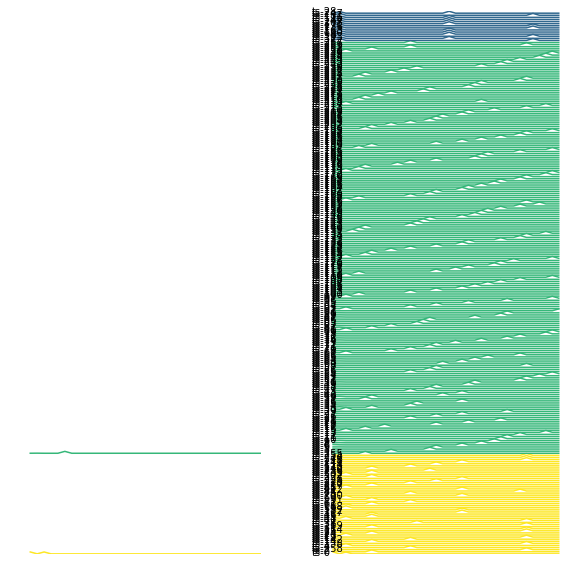

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = lambda idx: "ts-" + str(idx)
model.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=3)

In [20]:
data_sb["Clusters"] = clusters

In [30]:
data_sb[data_sb["Clusters"]==0]["dest cou"].value_counts()

BH    12
SA    10
AE     9
DE     6
IN     6
GB     2
EG     1
QA     1
FR     1
Name: dest cou, dtype: int64

In [32]:
data_sb[data_sb["Clusters"]==2]["dest cou"].value_counts()

HK    9
SG    5
Name: dest cou, dtype: int64

In [31]:
data_sb[data_sb["Clusters"]==1]["dest cou"].value_counts()

GB    14
DE    14
QA    12
AE    12
IN    11
NL    10
SA     9
US     9
BE     9
LB     9
FR     9
BD     8
IT     8
BH     7
CH     7
KR     7
PH     6
UA     6
MA     4
EG     4
MT     4
TR     3
GR     3
ES     3
HR     2
CA     1
ZA     1
PL     1
AU     1
CY     1
BR     1
CZ     1
Name: dest cou, dtype: int64